In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as cm
import datetime
from datetime import timedelta
from epiweeks import Week, Year
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import statsmodels.nonparametric.smoothers_lowess as lowess
from pandas.plotting import lag_plot
from sklearn.linear_model import LinearRegression

import glob
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
def conv_epiweek(x):
    week=Week.fromdate(pd.to_datetime(x))
    return str(week.year)+'EW'+'{:02}'.format(week.week)

def get_LinReg(y,x):
    model=LinearRegression()
    model.fit(x.reshape(-1,1), y.reshape(-1,1))
    yp=model.predict(x.reshape(-1,1))
    return yp

def get_index_days(ind,win):
    x=[(ind[i]-ind[0]).days for i in range(0,win)]
    return np.array(x).reshape(-1,1)

def get_rolling_LinReg(df,smooth='',win=3,v=False):
    if smooth:
        col='log_viral_load'+'_'+smooth
        col_out='_smooth'
    else:
        col='log_viral_load'
        col_out=''
    tempdf=df.copy()
    tot_len=tempdf.shape[0]
    win=win
    rolling_range=tot_len-win+1
    lindf=pd.DataFrame(index=tempdf.sample_collect_date,columns=tempdf.sample_collect_date)
    for i in range(0,rolling_range):
        try:
            yy=tempdf.iloc[i:i+win]
            yy=yy.reset_index(drop=True)
            x=get_index_days(yy.sample_collect_date,win)
            y=yy[col].values.reshape(-1,1)
            yp=(get_LinReg(y,x))
            lindf.loc[yy.sample_collect_date,yy.sample_collect_date[win-1]]=yp[:,0]
            slope=(yp[-1]-yp[0])/(x[-1]-x[0]+1)
            temp_ind=tempdf[tempdf.sample_collect_date==yy.sample_collect_date[win-1]].index
            tempdf.loc[temp_ind,'slope'+col_out]=slope
            tempdf.loc[temp_ind,'pct_daily_change'+col_out]=((10**slope)-1)*100            
        except Exception as e:
            if v:
                print(e)
            continue
    return tempdf,lindf

In [3]:
ssh_df=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/county_mappings/ssh_name_mapping.csv')
ssh_map=dict(zip(ssh_df['new_file_name'],ssh_df['dashboard_name']))

In [4]:
df=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/opioids_url/Sewershed_PCR_Conc.csv',date_parser=True)
df.sample_collect_date=pd.to_datetime(df.sample_collect_date)
df.test_result_date=pd.to_datetime(df.test_result_date)
df.loc[:,'EW']=df.sample_collect_date.apply(lambda x: conv_epiweek(x))
temp=df.groupby(['sewershed','EW']).size().reset_index().rename(columns={0:'no_of_samples'})
df=df.merge(temp)

In [10]:
cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/opioids_url/Sewershed_Case_Counts.csv",parse_dates=['event_date'])


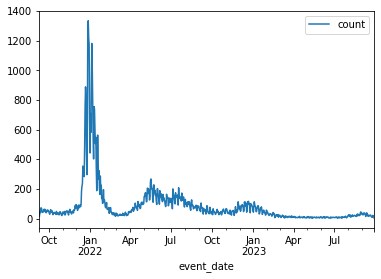

In [14]:
cases[cases.sewershed=='ARenew'].plot(x='event_date',y='count')

In [11]:
len(df[df.sample_collect_date>='2023-03-01'].wwtp_name.unique())

36

In [6]:
df.loc[:,'sewershed']=df.sewershed.replace(ssh_map)

In [7]:
len(df[df.sample_collect_date>='2022-09-01'].sewershed.unique())

30

Text(0.5, 1.0, 'Number of sites reporting twice weekly')

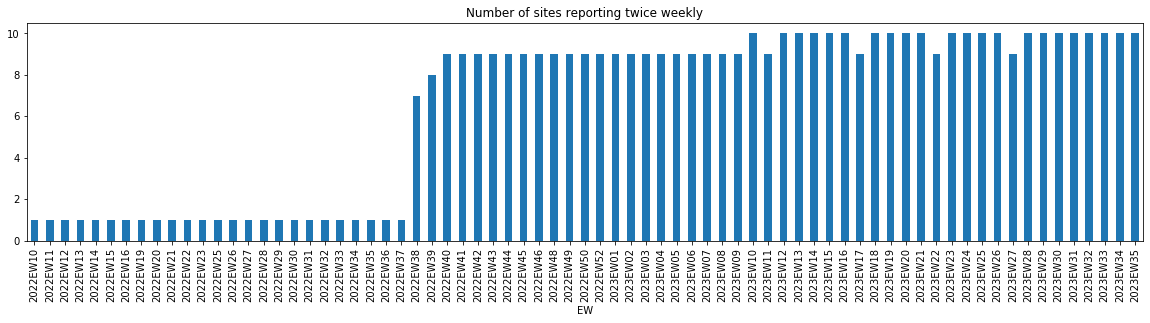

In [7]:
ax=temp[(temp.no_of_samples==2)].groupby(['EW']).size().plot.bar(figsize=(20, 4))
ax.set_title('Number of sites reporting twice weekly')
# plt.savefig('plots/twice_weekly_sites.pdf',bbox_inches='tight')

In [24]:
ddf=df[df.no_of_samples==2]
temp1=ddf.groupby(['EW','wwtp_name','sewershed'])['sample_collect_date'].agg([min]).reset_index().rename(columns={'min':'sample_collect_date'})
temp1.loc[:,'test']='test1'
temp2=ddf.groupby(['EW','wwtp_name','sewershed'])['sample_collect_date'].agg([max]).reset_index().rename(columns={'max':'sample_collect_date'})
temp2.loc[:,'test']='test2'
temp1=temp1.append(temp2)

ddf=ddf.merge(temp1)
temp3=ddf.groupby(['EW','wwtp_name','sewershed']).mean().reset_index()
temp3.loc[:,'test']='mean_test'
ddf=ddf.append(temp3)

In [34]:
sdf=df[df.no_of_samples==1]
sdf.loc[:,'test']='one_test'
sdf=sdf.append(temp3)

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [15]:
# _,ax=plt.subplots(figsize=(14,5))
# l='MooresCreek'
# color=['bo','rd']
# i=0
# for tt in ['test1','test2','test_mean']:
#     cols=['sample_collect_date',]
#     locdf=ddf[(ddf.sewershed==l)&(ddf.test==tt)]
#     locdf=locdf.set_index('sample_collect_date')
#     locdf=locdf.sort_index()
#     ax.plot(locdf.index,np.log(locdf['viral_load']))
#     i+=1
# ax.legend()

In [41]:
ddf.loc[:,'log_viral_load']=np.log10(ddf['viral_load'])

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [42]:
locs=ddf.sewershed.unique()
for win in [3,5]:
    for l in locs:
        if win==3:
            trend='ST'
        elif win==5:
            trend='LT'
        tempdf=ddf[(ddf.sewershed==l)][['sample_collect_date','viral_load','log_viral_load']]
        tempdf=tempdf.sort_values(by='sample_collect_date')
        tempdf.loc[tempdf.viral_load==0,'viral_load']=np.nan
        tempdf.viral_load=tempdf.viral_load.ffill()
        tempdf.loc[:,'log_viral_load']=np.log10(tempdf['viral_load'])
        tempdf.loc[:,'log_viral_load_smooth']=tempdf['log_viral_load'].rolling(7).mean()
        tempdf1,lindf1=get_rolling_LinReg(tempdf,smooth='',win=win)
        tempdf1.loc[:,'sewershed']=l
        tempdf2,lindf2=get_rolling_LinReg(tempdf,smooth='smooth',win=win)
        tempdf2.loc[:,'sewershed']=l
        bothdf=tempdf1.merge(tempdf2)
        bothdf.to_csv('output/slope_pct/{}_two_samples_{}.csv'.format(l,trend),index=None)
        lindf1.to_csv('output/lin_reg/{}_two_samples_{}.csv'.format(l,trend))
        lindf2.to_csv('output/lin_reg/{}_two_samples_{}_smooth.csv'.format(l,trend))
        print(l)

Parkins Mill
Alexandria Renew
North River
Blacksburg
Pepper's Ferry
Roanoke
Coeburn Norton Wise
Moores Creek
Lynchburg
RockyMount
Parkins Mill
Alexandria Renew
North River
Blacksburg
Pepper's Ferry
Roanoke
Coeburn Norton Wise
Moores Creek
Lynchburg
RockyMount


In [36]:
sdf

,sample_id,wwtp_name,sewershed,population_served,sample_type,sample_matrix,sample_collect_date,sample_collect_time,flow_rate,test_result_date,pcr_target_avg_conc,pcr_target_below_lod,lod_sewage,rec_eff_percent,viral_load,EW,no_of_samples,test
0,DCLS_SMP_WW1_WK1,atlantic,HRSD_AT,343016,24-hr flow-weighted composite,raw wastewater,2021-09-13,09:22,28.10,2021-09-20,40000.000000,0.0,1350,41.10,4.250000e+12,2021EW37,1,one_test
1,DCLS_SMP_WW2_WK1,HRSD: Virginia Initiative Plant,Virginia Initiative Plant,192347,24-hr flow-weighted composite,raw wastewater,2021-09-13,11:12,23.70,2021-09-20,41875.000000,0.0,1350,33.02,3.750000e+12,2021EW37,1,one_test
2,DCLS_SMP_WW3_WK1,Moores Creek Advanced Water Resource Rec,Moores Creek,118266,24-hr flow-weighted composite,post grit removal,2021-09-13,00:00,10.10,2021-09-20,12500.000000,0.0,1350,14.39,4.780000e+11,2021EW37,1,one_test
3,DCLS_SMP_WW4_WK1,HRSD: Nansemond,Nansemond,197608,grab,raw wastewater,2021-09-14,12:14,15.30,2021-09-20,28750.000000,0.0,1350,14.39,1.670000e+12,2021EW37,1,one_test
4,DCLS_SMP_WW5_WK1,City of Danville Northside Wastewater Tr,Danville,47000,24-hr flow-weighted composite,raw wastewater,2021-09-13,00:01,5.10,2021-09-20,9688.000000,0.0,1350,36.02,1.860000e+11,2021EW37,1,one_test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,NaN,North River Wastewater Treatment Facilit,North River,81000,NaN,NaN,NaT,NaN,13.40,NaT,10709.475615,0.5,6200,NaN,5.655000e+11,2023EW35,2,mean_test
472,NaN,Parkins Mill Wastewater Treatment Facili,Parkins Mill,16563,NaN,NaN,NaT,NaN,2.75,NaT,793.430819,1.0,6200,NaN,8.240000e+09,2023EW35,2,mean_test
473,NaN,Pepper's Ferry Regional Wastewater Treat,Pepper's Ferry,70000,NaN,NaN,NaT,NaN,3.05,NaT,12322.085605,0.0,6200,NaN,1.410000e+11,2023EW35,2,mean_test
474,NaN,Roanoke Regional Water Pollution Control,Roanoke,300000,NaN,NaN,NaT,NaN,33.00,NaT,9149.131088,0.5,6200,NaN,1.090500e+12,2023EW35,2,mean_test


In [37]:
# sdf=df[df.no_of_samples==1]

In [46]:
slocs=sdf.sewershed.unique()
for win in [3,5]:
    for l in slocs:
        if win==3:
            trend='ST'
        elif win==5:
            trend='LT'
        tempdf=sdf[(sdf.sewershed==l)][['sample_collect_date','viral_load']]
        tempdf=tempdf.sort_values(by='sample_collect_date')
        tempdf.loc[tempdf.viral_load==0,'viral_load']=np.nan
        tempdf.viral_load=tempdf.viral_load.ffill()
        tempdf.loc[:,'log_viral_load']=np.log10(tempdf['viral_load'])
        tempdf.loc[:,'log_viral_load_smooth']=tempdf['log_viral_load'].rolling(7).mean()
        tempdf1,lindf1=get_rolling_LinReg(tempdf,smooth='',win=win)
        tempdf1.loc[:,'sewershed']=l
        tempdf2,lindf2=get_rolling_LinReg(tempdf,smooth='smooth',win=win)
        tempdf2.loc[:,'sewershed']=l
        bothdf=tempdf1.merge(tempdf2)
        bothdf.to_csv('output/slope_pct/{}_one_samples_{}.csv'.format(l,trend),index=None)
        lindf1.to_csv('output/lin_reg/{}_one_samples_{}.csv'.format(l,trend)) 
        lindf2.to_csv('output/lin_reg/{}_one_samples_{}_smooth.csv'.format(l,trend))
        print(l)

HRSD_AT
Virginia Initiative Plant
Moores Creek
Nansemond
Danville
HL Mooney
Onancock
Richmond
Alexandria Renew
RutledgeCreek
Upper Occoquan
Parkins Mill
North River
Williamsburg
Purcellville
Lynchburg
Blacksburg
Christiansburg
Pound
Pepper's Ferry
Roanoke
Aquia
Little Falls Run
Wolf Creek
Coeburn Norton Wise
HRSD_ATCE
Lebanon
Independence
Hillsville
Wytheville
Clintwood
Loudoun
HRSD_AB
HRSD_BH
HRSD_JR
HRSD_YR
RockyMount
HRSD_AT
Virginia Initiative Plant
Moores Creek
Nansemond
Danville
HL Mooney
Onancock
Richmond
Alexandria Renew
RutledgeCreek
Upper Occoquan
Parkins Mill
North River
Williamsburg
Purcellville
Lynchburg
Blacksburg
Christiansburg
Pound
Pepper's Ferry
Roanoke
Aquia
Little Falls Run
Wolf Creek
Coeburn Norton Wise
HRSD_ATCE
Lebanon
Independence
Hillsville
Wytheville
Clintwood
Loudoun
HRSD_AB
HRSD_BH
HRSD_JR
HRSD_YR
RockyMount


In [49]:
for tts in ['test1','test2']:
    if tts=='test1':
        samp='first'
    elif tts=='test2':
        samp='second'
    stdf=ddf[ddf.test==tts]
    slocs=stdf.sewershed.unique()
    for win in [3,5]:
        for l in slocs:
            if win==3:
                trend='ST'
            elif win==5:
                trend='LT'
            tempdf=stdf[(stdf.sewershed==l)][['sample_collect_date','viral_load']]
            tempdf=tempdf.sort_values(by='sample_collect_date')
            tempdf.loc[tempdf.viral_load==0,'viral_load']=np.nan
            tempdf.viral_load=tempdf.viral_load.ffill()
            tempdf.loc[:,'log_viral_load']=np.log10(tempdf['viral_load'])
            tempdf.loc[:,'log_viral_load_smooth']=tempdf['log_viral_load'].rolling(7).mean()
            tempdf1,lindf1=get_rolling_LinReg(tempdf,smooth='',win=win,v=True)
            tempdf1.loc[:,'sewershed']=l
            tempdf2,lindf2=get_rolling_LinReg(tempdf,smooth='smooth',win=win,v=True)
            tempdf2.loc[:,'sewershed']=l
            bothdf=tempdf1.merge(tempdf2)
            bothdf.to_csv('output/slope_pct/{}_{}_two_samples_{}.csv'.format(l,samp,trend),index=None)
            lindf1.to_csv('output/lin_reg/{}_{}_two_samples_{}.csv'.format(l,samp,trend)) 
            lindf2.to_csv('output/lin_reg/{}_{}_two_samples_{}_smooth.csv'.format(l,samp,trend))
            print(l,samp,trend)

Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Parkins Mill first ST
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Alexandria Renew first ST
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains N

In [234]:
temp1=tempdf.copy()

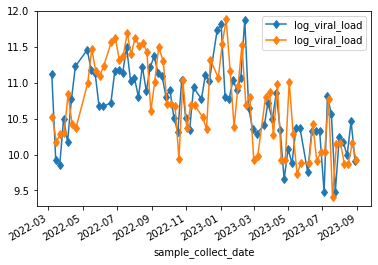

In [239]:
ax=temp1.plot(x='sample_collect_date',y='log_viral_load',marker='d')
tempdf.plot(x='sample_collect_date',y='log_viral_load',ax=ax,marker='d')

,sample_collect_date,viral_load,log_viral_load,log_viral_load_smooth
1,2022-03-08,3.380000e+10,10.528917,NaN
3,2022-03-15,1.510000e+10,10.178977,NaN
5,2022-03-22,1.930000e+10,10.285557,NaN
7,2022-03-29,2.010000e+10,10.303196,NaN
9,2022-04-05,6.890000e+10,10.838219,NaN
...,...,...,...,...
857,2023-08-02,1.450000e+10,10.161368,10.065260
877,2023-08-09,7.480000e+09,9.873902,10.060090
897,2023-08-16,7.400000e+09,9.869232,10.037211
917,2023-08-23,1.440000e+10,10.158362,10.055637


In [187]:
tt=tt.asfreq('D')

In [211]:
ttf=tt.ffill()

In [214]:
tt

,log_viral_load
sample_collect_date,
2021-09-13,12.176091
2021-09-14,NaN
2021-09-15,NaN
2021-09-16,NaN
2021-09-17,NaN
...,...
2023-08-31,NaN
2023-09-01,NaN
2023-09-02,NaN


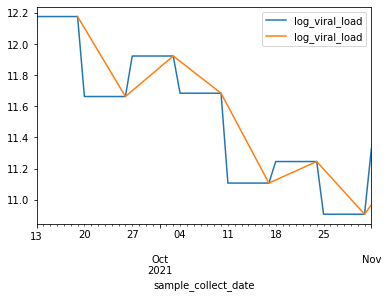

In [220]:
ax=ttf.iloc[:50].plot()
# tt.plot()
ttf.rolling(7).mean()[:50].plot(ax=ax)

(9, 12)

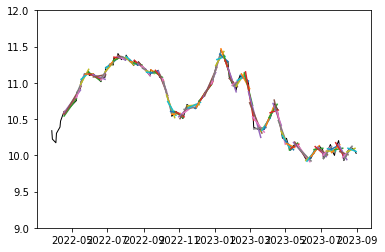

In [132]:
tr=12
ax=plt.plot(tempdf['sample_collect_date'],tempdf['log_viral_load_smooth'],color='k',linewidth=1)
# plt.scatter(tempdf['sample_collect_date'],tempdf['log_viral_load'])
for dt in lindf.columns[tr:]:    
    plt.plot(lindf.index[tr:],lindf.loc[lindf.index[tr:],dt])
plt.ylim([9,12])

In [170]:
sdf

,sample_id,wwtp_name,sewershed,population_served,sample_type,sample_matrix,sample_collect_date,sample_collect_time,flow_rate,test_result_date,pcr_target_avg_conc,pcr_target_below_lod,lod_sewage,rec_eff_percent,viral_load,EW,no_of_samples
0,DCLS_SMP_WW1_WK1,atlantic,HRSD_AT,343016,24-hr flow-weighted composite,raw wastewater,2021-09-13,09:22,28.1,2021-09-20,40000.0,False,1350,41.10,4.250000e+12,2021EW37,1
1,DCLS_SMP_WW2_WK1,HRSD: Virginia Initiative Plant,HRSD_VIP,192347,24-hr flow-weighted composite,raw wastewater,2021-09-13,11:12,23.7,2021-09-20,41875.0,False,1350,33.02,3.750000e+12,2021EW37,1
2,DCLS_SMP_WW3_WK1,Moores Creek Advanced Water Resource Rec,MooresCreek,118266,24-hr flow-weighted composite,post grit removal,2021-09-13,00:00,10.1,2021-09-20,12500.0,False,1350,14.39,4.780000e+11,2021EW37,1
3,DCLS_SMP_WW4_WK1,HRSD: Nansemond,HRSD_NA,197608,grab,raw wastewater,2021-09-14,12:14,15.3,2021-09-20,28750.0,False,1350,14.39,1.670000e+12,2021EW37,1
4,DCLS_SMP_WW5_WK1,City of Danville Northside Wastewater Tr,Danville,47000,24-hr flow-weighted composite,raw wastewater,2021-09-13,00:01,5.1,2021-09-20,9688.0,False,1350,36.02,1.860000e+11,2021EW37,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3176,DCLS_SMP_WW38_WK104,Town of Rocky Mount WWTP,RockyMount,5000,24-hr flow-weighted composite,post grit removal,2023-09-04,07:10,0.5,2023-09-07,3551.0,True,6200,0.57,6.710000e+09,2023EW36,1
3177,DCLS_SMP_WW42_WK104,HRSD: Army Base,HRSD_AB,78322,grab,raw wastewater,2023-09-05,09:18,11.3,2023-09-07,2287.0,True,6200,0.25,9.820000e+10,2023EW36,1
3178,DCLS_SMP_WW43_WK104,HRSD: Boat Harbor,HRSD_BH,118497,grab,raw wastewater,2023-09-05,09:18,10.8,2023-09-07,1326.0,True,6200,0.23,5.430000e+10,2023EW36,1
3179,DCLS_SMP_WW44_WK104,HRSD: James River,HRSD_JR,141543,grab,raw wastewater,2023-09-05,08:47,12.2,2023-09-07,10174.0,False,6200,1.52,4.710000e+11,2023EW36,1


In [40]:
pd.qcut(sdf[sdf.wwtp_name=='HRSD: York River']['viral_load'],q=5)

2201    (342800000000.0, 1420000000000.0]
2249              (-0.001, 67400000000.0]
2290    (342800000000.0, 1420000000000.0]
2330              (-0.001, 67400000000.0]
2370     (228600000000.0, 342800000000.0]
2408      (67400000000.0, 114240000000.0]
2446    (342800000000.0, 1420000000000.0]
2520              (-0.001, 67400000000.0]
2556              (-0.001, 67400000000.0]
2599     (114240000000.0, 228600000000.0]
2637      (67400000000.0, 114240000000.0]
2678              (-0.001, 67400000000.0]
2717     (228600000000.0, 342800000000.0]
2757     (114240000000.0, 228600000000.0]
2797      (67400000000.0, 114240000000.0]
2833     (114240000000.0, 228600000000.0]
2875      (67400000000.0, 114240000000.0]
2915    (342800000000.0, 1420000000000.0]
2954     (114240000000.0, 228600000000.0]
2995     (228600000000.0, 342800000000.0]
3035      (67400000000.0, 114240000000.0]
3075     (228600000000.0, 342800000000.0]
3114    (342800000000.0, 1420000000000.0]
3151     (114240000000.0, 22860000